In [1]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from scipy import interpolate
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
import yaml
import matplotlib.patheffects as path_effects
import pickle as pk
from matplotlib.ticker import Locator
%matplotlib inline


In [2]:
map220 = enmap.read_map('/project/r/rbond/jorlo/stitched_Beam_filteredMap.fits')

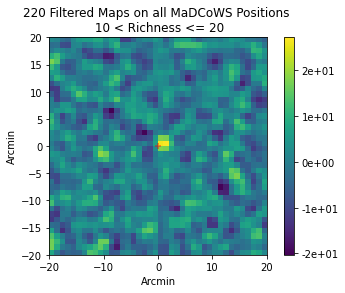

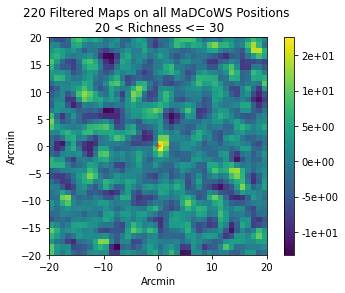

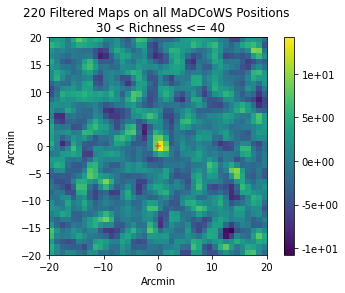

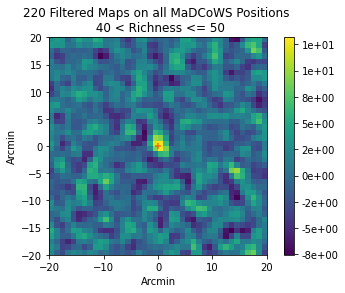

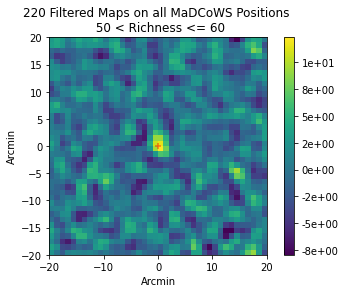

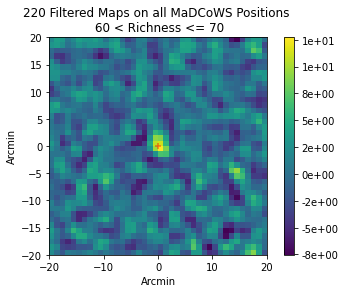

In [23]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

central_t = []
highest_t = []
map_var = []

for j in range(0,70, 10):
    
    flag = np.where((rich<j) & (rich<=j+10))[0]
    
    if len(flag) == 0: continue
    
    ra_temp, dec_temp = ra[flag], dec[flag]
    
    stack = 0
    divisor = 0

    for i in range(len(ra_temp)):
        stamp = reproject.postage_stamp(map220, ra_temp[i], dec_temp[i], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor

    plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
    plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
    plt.colorbar(plot, format='%.0e')
    plt.title('220 Filtered Maps on all MaDCoWS Positions \n {} < Richness <= {}'.format(j, j+10))

    plt.xlabel('Arcmin')
    plt.ylabel('Arcmin')
    plt.savefig('./plots/{}_{}_220_filtered_mdcw.pdf'.format(j,j+10))
    plt.savefig('./plots/{}_{}_220_filtered_mdcw.png'.format(j,j+10), dpi = 300)
    plt.show()
    plt.close()

    highest_t.append(np.amin(stack[29:31, 29:31]))
    central_t.append(np.mean(stack[19:21, 19:21]))

    map_var.append(np.sqrt(np.var(stack[0:15, 0:15])))

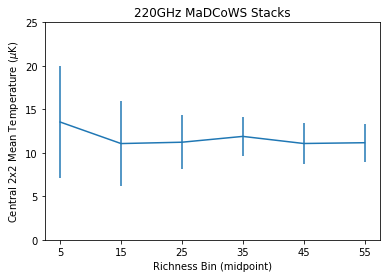

In [31]:
xrange = range(5,65, 10)
plt.errorbar(xrange, central_t, yerr = map_var)
plt.ylim(0,25)
plt.xticks(xrange)
plt.title(r'220GHz MaDCoWS Stacks')
plt.xlabel('Richness Bin (midpoint)')
plt.ylabel(r'Central 2x2 Mean Temperature ($\mu$K)')
plt.savefig('./plots/220GHz/rich_central_temp.pdf')
plt.savefig('./plots/220GHz/rich_central_temp.png', dpi = 300)
plt.show()
plt.close()
